#### Prepared for Gabor's Data Analysis

### Data Analysis for Business, Economics, and Policy
by Gabor Bekes and  Gabor Kezdi
 
Cambridge University Press 2021

**[gabors-data-analysis.com ](https://gabors-data-analysis.com/)**

 License: Free to share, modify and use for educational purposes. 
 Not to be used for commercial purposes.


### Chapter 24
**CH24B Estimating the impact of replacing football team managers**

using the football dataset

version 1.0 2021-05-05

In [1]:
import os
import sys
import warnings
from datetime import datetime as dt

import numpy as np
import pandas as pd
import pyfixest as pf
import seaborn as sns
import matplotlib.pyplot as plt

warnings.filterwarnings("ignore")

In [2]:
# Current script folder
current_path = os.getcwd()
dirname = current_path.split("da_case_studies")[0]

# location folders
data_in = dirname + "da_data_repo/football/clean/"
data_out = dirname + "da_case_studies/ch24-football-manager-replace/"
output = dirname + "da_case_studies/ch24-football-manager-replace/output/"

func = dirname + "da_case_studies/ch00-tech-prep/"
sys.path.append(func)


In [3]:
# Import the prewritten helper functions
from py_helper_functions import *

# Set custom color scheme for plots
sns.set_theme(rc=da_theme, palette=color)

## Loading and preparing data

In [4]:
data = pd.read_csv(data_in + "football_managers_workfile.csv")
# data = pd.read_csv("https://osf.io/t6dgh/download")


In [5]:
data["date"] = data["date"].apply(lambda x: dt.strptime(x.strip()[0:10], "%Y-%m-%d"))


In [6]:
# describe data
data[["season", "team", "gameno", "points"]].describe()


,season,gameno,points
count,8360.000000,8360.000000,8360.000000
mean,2013.000000,19.500000,1.375957
std,3.162467,10.966512,1.318578
min,2008.000000,1.000000,0.000000
25%,2010.000000,10.000000,0.000000
50%,2013.000000,19.500000,1.000000
75%,2016.000000,29.000000,3.000000
max,2018.000000,38.000000,3.000000


In [7]:
data["shifted"] = (
    data.sort_values(by=["team", "season", "date"])
    .groupby(["team", "season"])["manager_id"]
    .shift()
)  # helper column
data = (
    data.sort_values(by=["team", "season", "date"])
    .reset_index(drop=True)
    .assign(
        managchange=lambda x: np.where(  # create this variable based on ifelse with np.where
            (x["manager_id"] == x["shifted"])
            | (pd.isnull(x["shifted"])),  # this is the first condition
            np.where(
                pd.isnull(x["shifted"]), np.nan, 0
            ),  # if first is true the true value is a second condition
            1,  # if other conditions are false then this value will be assigned (first condition's false value)
        )
    )
    .drop("shifted", axis=1)  # dropping helper column
)
data["countmanagchange"] = data.groupby(["team", "season"])["managchange"].transform(
    sum
)  # counting changes with groupby

In [8]:
data["managchange"].value_counts(dropna=False)


managchange
0.0    8046
NaN     220
1.0      94
Name: count, dtype: int64

In [9]:
data[["countmanagchange", "team", "season"]].groupby("countmanagchange").apply(
    lambda x: x.groupby(["team", "season"]).ngroups
)


countmanagchange
0.0    151
1.0     48
2.0     17
3.0      4
dtype: int64

##   BALANCED PANEL

We define intervention as ***management change***:
 - at least 12 games before (since season started or previous management changed)
 - at least 12 games after (till season ends or next management change)

In [10]:
data = data.merge(
    data.sort_values(by=["team", "season", "date"])
    .groupby(["team", "season"])
    .agg(max_gameno=("gameno", max))
    .reset_index(),
    on=["team", "season"],
)


In [11]:
data_aux = data.loc[lambda x: x["managchange"] == 1].reset_index(drop=True)


In [12]:
data_aux["gamesbefore"] = None
data_aux.loc[0, "gamesbefore"] = data_aux.loc[0, "gameno"] - 1
for i in range(1, data_aux.shape[0]):
    if (data_aux.loc[i, "season"] == data_aux.loc[i - 1, "season"]) & (
        data_aux.loc[i, "team"] == data_aux.loc[i - 1, "team"]
    ):
        data_aux.loc[i, "gamesbefore"] = (
            data_aux.loc[i, "gameno"] - data_aux.loc[i - 1, "gameno"]
        )
    else:
        data_aux.loc[i, "gamesbefore"] = data_aux.loc[i, "gameno"] - 1


In [13]:
data_aux["gamesafter"] = None
for i in range(0, data_aux.shape[0] - 1):
    if (data_aux.loc[i, "season"] == data_aux.loc[i + 1, "season"]) & (
        data_aux.loc[i, "team"] == data_aux.loc[i + 1, "team"]
    ):
        data_aux.loc[i, "gamesafter"] = (
            data_aux.loc[i + 1, "gameno"] - data_aux.loc[i, "gameno"]
        )
    else:
        data_aux.loc[i, "gamesafter"] = (
            data_aux.loc[i, "max_gameno"] - data_aux.loc[i, "gameno"]
        )


In [14]:
data_aux["intervention"] = np.where(
    (data_aux["gamesbefore"] < 12) | (data_aux["gamesafter"] < 12),
    0,
    data_aux["managchange"],
)


In [15]:
data_aux = data_aux[["team", "season", "date", "intervention"]]


In [16]:
data_aux["intervention"].describe()


count    94.000000
mean      0.351064
std       0.479862
min       0.000000
25%       0.000000
50%       0.000000
75%       1.000000
max       1.000000
Name: intervention, dtype: float64

In [17]:
data_balanced = data.merge(data_aux, on=["team", "season", "date"], how="left")
data_balanced["intervention"] = data_balanced["intervention"].fillna(0)


In [18]:
data_balanced = data_balanced.merge(
    data_balanced.groupby(["team", "season"])
    .agg(countinterv=("intervention", "sum"))
    .reset_index(),
    on=["team", "season"],
    how="left",
)


In [19]:
data_balanced.intervention.describe()


count    8360.000000
mean        0.003947
std         0.062708
min         0.000000
25%         0.000000
50%         0.000000
75%         0.000000
max         1.000000
Name: intervention, dtype: float64

In [20]:
data_balanced.countinterv.describe()


count    8360.000000
mean        0.150000
std         0.357093
min         0.000000
25%         0.000000
50%         0.000000
75%         0.000000
max         1.000000
Name: countinterv, dtype: float64

In [21]:
data_balanced = data_balanced.merge(
    data_balanced.groupby(["team", "season"])
    .apply(lambda x: np.nanmin(np.where(x["intervention"] == 1, x["gameno"], np.nan)))
    .reset_index()
    .rename(columns={0: "intervention_time"}),
    on=["team", "season"],
    how="left",
)


In [22]:
data_balanced = data_balanced.merge(
    data_balanced.groupby(["team", "season", "date"])
    .apply(
        lambda x: np.where(
            np.isfinite(x["intervention_time"]),
            x["gameno"] - x["intervention_time"],
            np.nan,
        )[0]
    )
    .reset_index()
    .rename(columns={0: "t_event"}),
    on=["team", "season", "date"],
    how="left",
)


In [23]:
data_balanced["t_event"] = data_balanced.groupby(["team", "season", "date"])[
    "t_event"
].transform(lambda x: np.where((x >= 0) & (x <= 38), x + 1, x))


In [24]:
data_balanced = data_balanced.loc[
    lambda x: ((x["countinterv"] == 1) & (x["t_event"] >= -12) & (x["t_event"] <= 12))
    | (x["countmanagchange"] == 0)
]

In [25]:
data_balanced.groupby("countinterv").apply(
    lambda x: x.groupby(["team", "season"]).ngroups
)


countinterv
0.0    151
1.0     33
dtype: int64

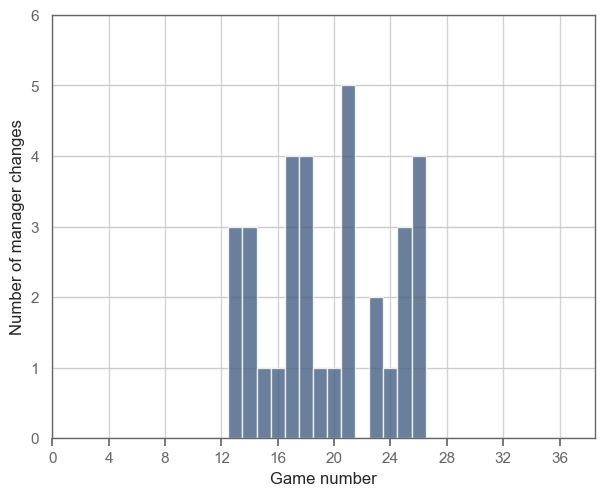

In [26]:
# figure: average number interventions by game number
fig, ax = plt.subplots(figsize=(7, 5.5))

fig = sns.barplot(
    data=data_balanced,
    x="gameno",
    y="intervention",
    estimator="sum",
    ci=None,
    width=1,
    alpha=0.8,
    ax=ax,
)

plt.ylabel("Number of manager changes")
plt.xlabel("Game number")
plt.ylim(0, 6)
plt.xticks(np.arange(-1, 36, 4), labels=np.arange(0, 37, 4))
plt.grid(axis="x", linestyle="-", color="lightgray")
plt.show()

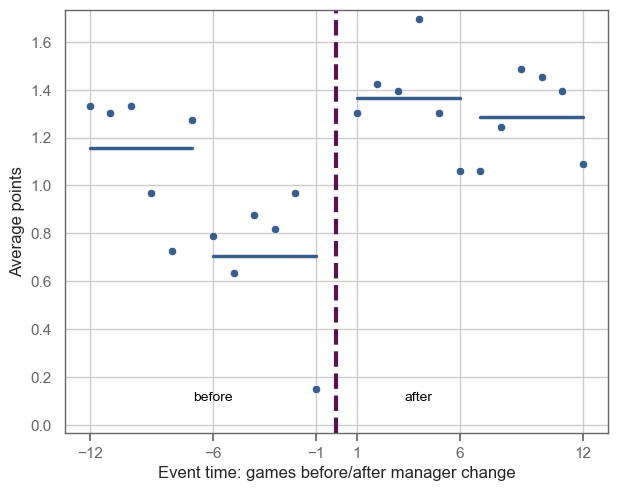

In [27]:
data_plot = (
    data_balanced.groupby("t_event")
    .agg(mean=("points", "mean"))
    .reset_index()
    .assign(
        t_event_6=lambda df: pd.cut(
            df["t_event"], bins=[-13, -6, 0, 1, 7, 13], right=False
        )
    )
)
data_plot = data_plot.merge(
    data_plot.groupby("t_event_6").agg(group_mean=("mean", "mean")),
    on="t_event_6",
    how="left",
)

fig, ax = plt.subplots(figsize=(7, 5.5))

sns.scatterplot(data=data_plot, x="t_event", y="mean", ax=ax)

# Line plot for group means
for _, group_data in data_plot.groupby("t_event_6"):
    ax.plot(
        group_data["t_event"],
        group_data["group_mean"],
        linewidth=2.5,
        color=color[0],
    )

# Vertical line at x = 0
ax.axvline(x=0, color=color[2], linestyle="--", linewidth=3)

# Labels and axis customization
ax.set_xlabel("Event time: games before/after manager change")
ax.set_ylabel("Average points")
ax.set_xticks([-12, -6, -1, 1, 6, 12])
ax.set_xlim(-12, 12)
ax.set_yticks(np.arange(0, 1.8, 0.2))
ax.set_ylim(0, 1.7)

# Annotations
ax.text(4, 0.1, "after", fontsize=10, ha="center")
ax.text(-6, 0.1, "before", fontsize=10, ha="center")
add_margin(ax, x=0.05, y=0.02)

## CREATE CONTORL GROUP WITH PSEUDO-INTERVENTIONS

In [28]:
# for each game, define avg diff of points 12-7 before
# dip: avg diff of points 6-1 before minus 12-7 before


data_balanced["points_b_7_12"] = (
    data_balanced.sort_values(by=["team", "season", "date"])
    .groupby(["team", "season"])["points"]
    .transform(
        lambda x: x.shift(12)
        + x.shift(11)
        + x.shift(10)
        + x.shift(9)
        + x.shift(8)
        + x.shift(7),
    )
)

data_balanced["points_b_1_6"] = (
    data_balanced.sort_values(by=["team", "season", "date"])
    .groupby(["team", "season"])["points"]
    .transform(
        lambda x: x.shift(6)
        + x.shift(5)
        + x.shift(4)
        + x.shift(3)
        + x.shift(2)
        + x.shift(1),
    )
)

data_balanced = data_balanced.assign(
    dip=lambda df: df["points_b_1_6"] / 6 - df["points_b_7_12"] / 6
).assign(points_b_1=lambda df: df["points"].shift(1))


In [29]:
# summary stats of dip when intervention
data_balanced.loc[lambda x: x["intervention"] == 1][
    ["points_b_1_6", "points_b_7_12", "dip", "points_b_1"]
].describe()


,points_b_1_6,points_b_7_12,dip,points_b_1
count,33.000000,33.000000,33.000000,33.000000
mean,4.242424,6.939394,-0.449495,0.151515
std,2.512846,3.436381,0.567470,0.364110
min,0.000000,0.000000,-1.333333,0.000000
25%,2.000000,5.000000,-1.000000,0.000000
50%,4.000000,6.000000,-0.333333,0.000000
75%,7.000000,9.000000,0.000000,0.000000
max,9.000000,16.000000,1.166667,1.000000


In [30]:
# set ranges to define control group
points_b_7_12min = 5
points_b_7_12max = 8
dipmin = -1.33
dipmax = -0.166
points_b_1min = 0
points_b_1max = 0


In [31]:
data_balanced["pseudo"] = np.where(
    (data_balanced["countmanagchange"] == 0)
    & (data_balanced["dip"] >= dipmin)
    & (data_balanced["dip"] <= dipmax)
    & (data_balanced["points_b_7_12"] >= points_b_7_12min)
    & (data_balanced["points_b_7_12"] <= points_b_7_12max)
    & (data_balanced["points_b_1"] >= points_b_1min)
    & (data_balanced["points_b_1"] <= points_b_1max)
    & (data_balanced["gameno"] < (38 - 12)),
    1,
    0,
)


In [32]:
data_balanced["pseudo"].value_counts(dropna=False)


pseudo
0    6398
1     132
Name: count, dtype: int64

In [33]:
data_balanced.loc[lambda x: x["pseudo"] == 1].filter(
    ["points_b_7_12", "dip", "points_b_1"]
).describe()

,points_b_7_12,dip,points_b_1
count,132.000000,132.000000,132.0
mean,6.856061,-0.452020,0.0
std,1.027355,0.270496,0.0
min,5.000000,-1.166667,0.0
25%,6.000000,-0.666667,0.0
50%,7.000000,-0.500000,0.0
75%,8.000000,-0.166667,0.0
max,8.000000,-0.166667,0.0


 if more such games in a teamXseason, choose one randomly

In [34]:
rng = np.random.default_rng(27845)
data_balanced = pd.concat(
    [
        data_balanced.loc[~(data_balanced["pseudo"] == 1)],
        data_balanced.sort_values(by=["team", "season"])
        .loc[lambda x: x["pseudo"] == 1]
        .groupby(["team", "season"])
        .agg(rng.choice)
        .reset_index(),
    ]
).reset_index(drop=True)

**Note**: In the textbook (2021 edition) we say  "When there was more than one candidate game 
within the same season for the same team, we selected the first one in the season."


In fact we mean "..., we selected **one in the season randomly**."

In [35]:
data_balanced["pseudo"].value_counts(dropna=False)


pseudo
0    6398
1      67
Name: count, dtype: int64

In [36]:
data_balanced.loc[lambda x: x["pseudo"] == 1][["points_b_7_12", "dip", "points_b_1"]].describe()


,points_b_7_12,dip,points_b_1
count,67.000000,67.000000,67.0
mean,7.014925,-0.450249,0.0
std,0.895993,0.275264,0.0
min,5.000000,-1.166667,0.0
25%,7.000000,-0.583333,0.0
50%,7.000000,-0.500000,0.0
75%,8.000000,-0.166667,0.0
max,8.000000,-0.166667,0.0


In [37]:
data_balanced = data_balanced.merge(
    data_balanced.groupby(["team", "season"])
    .agg(countpseudo=("pseudo", sum))
    .reset_index(),
    on=["team", "season"],
    how="left",
)


In [38]:
data_balanced = data_balanced.merge(
    data_balanced.groupby(["team", "season"])
    .apply(lambda x: np.nanmin(np.where(x["pseudo"] == 1, x["gameno"], np.nan)))
    .reset_index()
    .rename(columns={0: "pseudo_time"}),
    on=["team", "season"],
    how="left",
)


In [39]:
data_balanced = data_balanced.merge(
    data_balanced.groupby(["team", "season", "date"])
    .apply(
        lambda x: np.where(
            np.isfinite(x["pseudo_time"]),
            x["gameno"] - x["pseudo_time"],
            np.nan,
        )[0]
    )
    .reset_index()
    .rename(columns={0: "t_pseudo"}),
    on=["team", "season", "date"],
    how="left",
)


In [40]:
data_balanced["t_pseudo"] = data_balanced.groupby(["team", "season", "date"])[
    "t_pseudo"
].transform(lambda x: np.where((x >= 0) & (x <= 38), x + 1, x))


In [41]:
data_balanced = (
    data_balanced.merge(
        data_balanced.groupby(["team", "season", "date"])
        .apply(
            lambda x: np.where(
                np.isnan(x["t_event"]),
                x["t_pseudo"],
                x["t_event"],
            )[0]
        )
        .reset_index()
        .rename(columns={0: "t_event"}),
        on=["team", "season", "date"],
        how="left",
    )
    .drop(columns=["t_event_x"])
    .rename(columns={"t_event_y": "t_event"})
)


In [42]:
data_balanced = data_balanced.loc[
    lambda x: (x["t_event"] >= -12) & (x["t_event"] <= 12)
]

In [43]:
data_balanced.groupby(["countinterv", "countpseudo"]).apply(
    lambda x: x.groupby(["team", "season"]).ngroups
)


countinterv  countpseudo
0.0          1              67
1.0          0              33
dtype: int64

## FIGURE with intervention and pseudo-intervention averages

In [44]:
data_plot = (
    data_balanced.groupby(["t_event", "countinterv", "countpseudo"])
    .agg(mean_points=("points", "mean"))
    .reset_index()
)
data_plot["t_event_6"] = pd.cut(
    data_plot["t_event"], bins=[-13, -6, 0, 1, 7, 13], right=False
)
data_plot["group_mean"] = data_plot.groupby(["t_event_6", "countpseudo"])[
    "mean_points"
].transform("mean")
data_plot["countpseudo"] = (
    data_plot["countpseudo"]
    .map({0: "intervention", 1: "pseudo-intervention"})
    .astype("category")
)

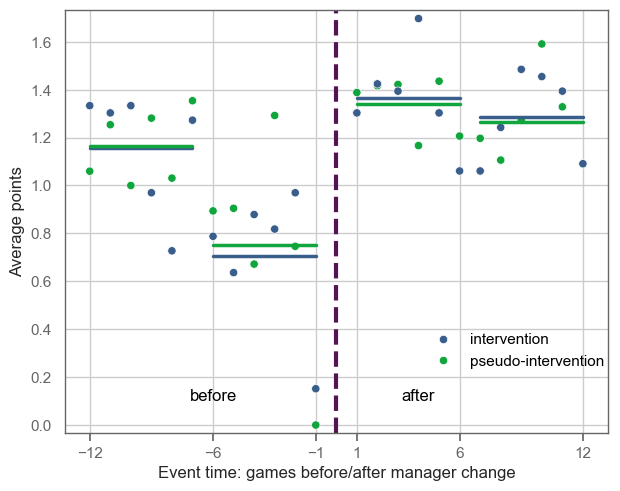

In [45]:
fig, ax = plt.subplots(figsize=(7, 5.5))

# Scatter plot for each group
sns.scatterplot(data=data_plot, x="t_event", y="mean_points", hue="countpseudo", ax=ax)

# Line plot for group means
for pseudo_value in sorted(data_plot["countpseudo"].unique()):
    group_data = data_plot[data_plot["countpseudo"] == pseudo_value]
    for _, sub_group in group_data.groupby("t_event_6"):
        ax.plot(
            sub_group["t_event"],
            sub_group["group_mean"],
            linewidth=2.5,
            color=color[1] if pseudo_value == "pseudo-intervention" else color[0],
        )

# Vertical line at x = 0
ax.axvline(x=0, color=color[2], linestyle="--", linewidth=3)

# Customize labels and axis
ax.set_xlabel("Event time: games before/after manager change")
ax.set_ylabel("Average points")
ax.set_xticks([-12, -6, -1, 1, 6, 12])
ax.set_xlim(-12, 12)
ax.set_yticks(np.arange(0, 1.8, 0.2))
ax.set_ylim(0, 1.7)

# Annotations
ax.text(4, 0.1, "after", ha="center")
ax.text(-6, 0.1, "before", ha="center")

ax.legend(loc="lower right", bbox_to_anchor=(1.02, 0.12), frameon=False)
add_margin(ax, x=0.05, y=0.02)

## REGRESSION with 6-game averages

In [46]:
data_balanced_agg = (
    data_balanced.assign(
        teamseason=lambda df: df["team"] + "_" + df["season"].astype(str)
    )
    .assign(
        t6_event=lambda df: pd.cut(
            df["t_event"], bins=[-13, -6, 0, 1, 7, 13], right=False
        )
    )
    .groupby(["teamseason", "t6_event"])
    .agg(treated=("countinterv", "mean"), points6avg=("points", "mean"))
    .reset_index()
    .dropna()
    .assign(Dp6avg=lambda df: df.groupby("teamseason")["points6avg"].transform("diff"))
)


In [47]:
data_balanced_agg = pd.concat(
    [data_balanced_agg, pd.get_dummies(data_balanced_agg["t6_event"])], axis=1
).iloc[:, [0, 1, 2, 3, 4, 5, 6, 8, 9]]


In [48]:
data_balanced_agg.columns = [
    "teamseason",
    "t6_event",
    "treated",
    "points6avg",
    "Dp6avg",
    "before_7_12",
    "before_1_6",
    "after_1_6",
    "after_7_12",
]


In [49]:
data_balanced_agg[["before_7_12", "before_1_6", "after_1_6", "after_7_12"]] = (
    data_balanced_agg[["before_7_12", "before_1_6", "after_1_6", "after_7_12"]].astype(
        int
    )
)

In [50]:
data_balanced_agg[["Dp6avg", "after_1_6", "after_7_12"]].describe()


,Dp6avg,after_1_6,after_7_12
count,300.000000,400.000000,400.000000
mean,0.038500,0.250000,0.250000
std,0.711752,0.433555,0.433555
min,-1.666667,0.000000,0.000000
25%,-0.500000,0.000000,0.000000
50%,-0.016667,0.000000,0.000000
75%,0.500000,0.250000,0.250000
max,2.333333,1.000000,1.000000


### FD REGRESSIONS

In [51]:
fd_treatment = pf.feols(
    "Dp6avg ~ after_1_6 + after_7_12",
    data=data_balanced_agg.loc[lambda x: x["treated"] == 1],
    vcov={"CRV1": "teamseason"},
)
fd_control = pf.feols(
    "Dp6avg ~ after_1_6 + after_7_12",
    data=data_balanced_agg.loc[lambda x: x["treated"] == 0],
    vcov={"CRV1": "teamseason"},
)
fd = pf.feols(
    "Dp6avg ~ after_1_6 + after_7_12 + treated + I(treated*after_1_6) + I(treated*after_7_12)",
    data=data_balanced_agg,
    vcov={"CRV1": "teamseason"},
)

### Table 24.1 The effect of replacing managers: FD regressions with changes between six-game-average points

In [52]:
pf.etable(
    [fd_treatment, fd_control, fd],
    model_heads=["Treatment", "Control", "Treatment + control"],
    head_order="h",
    labels={
        "Intercept": "Constant",
        "I(treated * after_1_6)": "treated × post 1 − 6",
        "I(treated * after_7_12)": "treated × post 7 − 12",
        "after_1_6": "post 1 − 6",
        "after_7_12": "post 7 − 12",
    },
    show_se_type=False,
    digits=2,
)

GT(_tbl_data=  level_0                level_1                     0                     1  \
0    coef             post 1 − 6   1.11*** <br> (0.19)   0.96*** <br> (0.09)   
1    coef            post 7 − 12     0.37* <br> (0.16)   0.36*** <br> (0.09)   
2    coef                treated                                               
3    coef   treated × post 1 − 6                                               
4    coef  treated × post 7 − 12                                               
5    coef               Constant  -0.45*** <br> (0.10)  -0.40*** <br> (0.04)   
6   stats           Observations                    99                   201   
7   stats          R<sup>2</sup>                  0.33                  0.35   

                      2  
0   0.96*** <br> (0.09)  
1   0.36*** <br> (0.09)  
2     -0.05 <br> (0.11)  
3      0.15 <br> (0.21)  
4      0.01 <br> (0.18)  
5  -0.40*** <br> (0.04)  
6                   300  
7                  0.35  , _body=<great_tables._gt_data.Body object at 0x15bd0a3c0>, _boxhead=Boxhead([ColInfo(var='level_0', type=<ColInfoTypeEnum.row_group: 3>, column_label='level_0', column_align='center', column_width=None), ColInfo(var='level_1', type=<ColInfoTypeEnum.stub: 2>, column_label='level_1', column_align='center', column_width=None), ColInfo(var='0', type=<ColInfoTypeEnum.default: 1>, column_label='(1)', column_align='center', column_width=None), ColInfo(var='1', type=<ColInfoTypeEnum.default: 1>, column_label='(2)', column_align='center', column_width=None), ColInfo(var='2', type=<ColInfoTypeEnum.default: 1>, column_label='(3)', column_align='center', column_width=None)]), _stub=<great_tables._gt_data.Stub object at 0x15bd088c0>, _spanners=Spanners([SpannerInfo(spanner_id='Treatment', spanner_level=1, spanner_label='Treatment', spanner_units=None, spanner_pattern=None, vars=['0'], built=None), SpannerInfo(spanner_id='Control', spanner_level=1, spanner_label='Control', spanner_units=None, spanner_pattern=None, vars=['1'], built=None), SpannerInfo(spanner_id='Treatment + control', spanner_level=1, spanner_label='Treatment + control', spanner_units=None, spanner_pattern=None, vars=['2'], built=None)]), _heading=Heading(title=None, subtitle=None, preheader=None), _stubhead=None, _source_notes=['Significance levels: * p < 0.05, ** p < 0.01, *** p < 0.001. Format of coefficient cell:\nCoefficient \n (Std. Error)'], _footnotes=[], _styles=[], _locale=<great_tables._gt_data.Locale object at 0x15bd0ac00>, _formats=[], _substitutions=[], _options=Options(table_id=OptionsInfo(scss=False, category='table', type='value', value=None), table_caption=OptionsInfo(scss=False, category='table', type='value', value=None), table_width=OptionsInfo(scss=True, category='table', type='px', value='auto'), table_layout=OptionsInfo(scss=True, category='table', type='value', value='fixed'), table_margin_left=OptionsInfo(scss=True, category='table', type='px', value='auto'), table_margin_right=OptionsInfo(scss=True, category='table', type='px', value='auto'), table_background_color=OptionsInfo(scss=True, category='table', type='value', value='#FFFFFF'), table_additional_css=OptionsInfo(scss=False, category='table', type='values', value=[]), table_font_names=OptionsInfo(scss=False, category='table', type='values', value=['-apple-system', 'BlinkMacSystemFont', 'Segoe UI', 'Roboto', 'Oxygen', 'Ubuntu', 'Cantarell', 'Helvetica Neue', 'Fira Sans', 'Droid Sans', 'Arial', 'sans-serif']), table_font_size=OptionsInfo(scss=True, category='table', type='px', value='16px'), table_font_weight=OptionsInfo(scss=True, category='table', type='value', value='normal'), table_font_style=OptionsInfo(scss=True, category='table', type='value', value='normal'), table_font_color=OptionsInfo(scss=True, category='table', type='value', value='#333333'), table_font_color_light=OptionsInfo(scss=True, category='table', type='value', value='#FFFFFF'), table_border_top_include=OptionsInfo(scss=False, category='table', type='boolean', value=True), t

### Extension, not included in the book

FE regression

In [53]:
fe_panel_treatment = pf.feols(
    "points6avg ~ before_7_12 + after_1_6 + after_7_12 | teamseason",
    data_balanced_agg.loc[lambda x: x["treated"] == 1],
    vcov={"CRV1": "teamseason"},
)
fe_panel_control = pf.feols(
    "points6avg ~ before_7_12 + after_1_6 + after_7_12 | teamseason",
    data_balanced_agg.loc[lambda x: x["treated"] == 0],
    vcov={"CRV1": "teamseason"},
)
fe_panel = pf.feols(
    "points6avg ~ before_7_12 + after_1_6 + after_7_12 + treated*before_7_12 + treated*after_1_6 + treated*after_7_12 | teamseason",
    data_balanced_agg,
    vcov={"CRV1": "teamseason"},
)

In [54]:
pf.etable(
    [fe_panel_treatment, fe_panel_control, fe_panel],
    custom_model_stats={
        "Within R<sup>2</sup>": [
            round(m._r2_within, 3)
            for m in [fe_panel_treatment, fe_panel_control, fe_panel]
        ]
    },
)

GT(_tbl_data=   level_0               level_1                      0  \
0     coef           before_7_12  0.449*** <br> (0.100)   
1     coef             after_1_6  0.657*** <br> (0.124)   
2     coef            after_7_12  0.581*** <br> (0.119)   
3     coef   treated:before_7_12                          
4     coef     treated:after_1_6                          
5     coef    treated:after_7_12                          
6       fe            teamseason                      x   
7    stats  Within R<sup>2</sup>                  0.279   
8    stats          Observations                    132   
9    stats             S.E. type         by: teamseason   
10   stats         R<sup>2</sup>                  0.589   

                        1                      2  
0   0.404*** <br> (0.038)  0.404*** <br> (0.038)  
1   0.555*** <br> (0.072)  0.555*** <br> (0.072)  
2   0.511*** <br> (0.072)  0.511*** <br> (0.072)  
3                             0.046 <br> (0.105)  
4                             0.101 <br> (0.142)  
5                             0.069 <br> (0.138)  
6                       x                      x  
7                   0.303                  0.293  
8                     268                    400  
9          by: teamseason         by: teamseason  
10                  0.488                  0.537  , _body=<great_tables._gt_data.Body object at 0x15a55fa40>, _boxhead=Boxhead([ColInfo(var='level_0', type=<ColInfoTypeEnum.row_group: 3>, column_label='level_0', column_align='center', column_width=None), ColInfo(var='level_1', type=<ColInfoTypeEnum.stub: 2>, column_label='level_1', column_align='center', column_width=None), ColInfo(var='0', type=<ColInfoTypeEnum.default: 1>, column_label='(1)', column_align='center', column_width=None), ColInfo(var='1', type=<ColInfoTypeEnum.default: 1>, column_label='(2)', column_align='center', column_width=None), ColInfo(var='2', type=<ColInfoTypeEnum.default: 1>, column_label='(3)', column_align='center', column_width=None)]), _stub=<great_tables._gt_data.Stub object at 0x15a55d220>, _spanners=Spanners([SpannerInfo(spanner_id='points6avg', spanner_level=1, spanner_label='points6avg', spanner_units=None, spanner_pattern=None, vars=['0', '1', '2'], built=None)]), _heading=Heading(title=None, subtitle=None, preheader=None), _stubhead=None, _source_notes=['Significance levels: * p < 0.05, ** p < 0.01, *** p < 0.001. Format of coefficient cell:\nCoefficient \n (Std. Error)'], _footnotes=[], _styles=[], _locale=<great_tables._gt_data.Locale object at 0x15a55f290>, _formats=[], _substitutions=[], _options=Options(table_id=OptionsInfo(scss=False, category='table', type='value', value=None), table_caption=OptionsInfo(scss=False, category='table', type='value', value=None), table_width=OptionsInfo(scss=True, category='table', type='px', value='auto'), table_layout=OptionsInfo(scss=True, category='table', type='value', value='fixed'), table_margin_left=OptionsInfo(scss=True, category='table', type='px', value='auto'), table_margin_right=OptionsInfo(scss=True, category='table', type='px', value='auto'), table_background_color=OptionsInfo(scss=True, category='table', type='value', value='#FFFFFF'), table_additional_css=OptionsInfo(scss=False, category='table', type='values', value=[]), table_font_names=OptionsInfo(scss=False, category='table', type='values', value=['-apple-system', 'BlinkMacSystemFont', 'Segoe UI', 'Roboto', 'Oxygen', 'Ubuntu', 'Cantarell', 'Helvetica Neue', 'Fira Sans', 'Droid Sans', 'Arial', 'sans-serif']), table_font_size=OptionsInfo(scss=True, category='table', type='px', value='16px'), table_font_weight=OptionsInfo(scss=True, category='table', type='value', value='normal'), table_font_style=OptionsInfo(scss=True, category='table', type='value', value='normal'), table_font_color=OptionsInfo(scss=True, category='table', type='value', value='#333333'), table_font_color_light=OptionsInfo(scss=True, category='table', type='value', value='#FFFFFF'), table_border_top_include=Opti